In [26]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


Define the slow manifold class

In [21]:
class SlowManifold():   
    def __init__(self, model_name, data_dir):
        """
        Initializes the SlowManifold class.
        
        Args:
            model_name (str): The name of the slow manifold model to load.
            data_dir (str): Directory path where the model files are stored.
            speedup_rate (float): The rate of speedup relative to the existing trajectory.
            reference_trajectory 
        """
        self.model_name = model_name
        self.data_dir = data_dir
        self._load_slow_model()

    def phi(self, xi, exps):
            """ Returns monomials for slow manifold.
            Args: 
                xi: Input array of shape (n_dimensions,) of positions
                exps: Exponent matrix of shape (n_monomials, n_dimensions). 
            Returns:
                monomials: Monomial matrix of shape (n_monomials). """ 
            #self.get_logger().info(f"exps: {exps.shape}")
            x = np.reshape(xi, (1,-1)) # reshaped to dim (n_dimensions,1)
            #self.get_logger().info(f"x: {x.shape}")
            x_expanded = np.tile(x, (exps.shape[0], 1)) #repeat for each monomial (n_monomials, n_dimensions)
            #self.get_logger().info(f"x_expanded: {x_expanded.shape}")
            monomials = np.prod(x_expanded**exps, axis=1) 
            return monomials

    def _load_slow_model(self):
        "Loads model for slow manifold predictions"
        model_path = os.path.join(self.data_dir, f'models/ssm/{self.model_name}.npz')

        # Load the model
        self.model = np.load(model_path)

        self.decoder_exp = np.array(self.model['decoder_exp'])
        self.const_coeff = np.array(self.model['Const_coeff'])
        self.decoder_coeff = np.array(self.model['decoder_coeff'])
        print('Loaded slow manifold model')


    def slow_manifold_callback(self, request):
        """
        Callback function that runs when the service is queried.
        Request contains: z (desired performance variable trajectory)
        Response contains: uopt (the found control inputs)
        """
        # decoder_exp shape = (83, 6)
        # const_coeff shape = (6, 1)
        # decoder_coeff shape = (6, 83)
        zf_des = np.array(request) # desired positions
        # self.get_logger().info(f"zf_des (zero centered from AVP) {zf_des}")
        # zf_des += self.rest_positions # It is already zero centered straight from the AVP... so we need to offset away from zero into the frame we learned the model in
        # self.get_logger().info(f"offset zf_des: {zf_des}")

        monomials = self.phi(zf_des, self.decoder_exp)
        u = (self.decoder_coeff @ monomials).reshape(self.const_coeff.shape[0], 1)

        self.const_coeff = self.const_coeff.reshape(self.const_coeff.shape[0],1)
        u_opt = u + self.const_coeff # add constant coefficients
        #self.get_logger().info(f"u_opt {u_opt}")

        # check control inputs are within the workspace
        u_opt = self.check_control_inputs(u_opt.flatten())
        response = u_opt.tolist()

        return response
    
    def check_control_inputs(self, u_opt):
        # reject vector norms of u that are too large
        tip_range, mid_range, base_range = 0.45, 0.35, 0.3 

        u1, u2, u3, u4, u5, u6 = u_opt[0], u_opt[1], u_opt[2], u_opt[3], u_opt[4], u_opt[5]

        # First we clip to max and min values
        u1 = np.clip(u1, -tip_range, tip_range)
        u6 = np.clip(u6, -tip_range, tip_range)
        u2 = np.clip(u2, -mid_range, mid_range)
        u5 = np.clip(u5, -mid_range, mid_range)
        u3 = np.clip(u3, -base_range, base_range)
        u4 = np.clip(u4, -base_range, base_range)

        # Compute control input vectors
        u1_vec = u1 * np.array([-np.cos(15 * np.pi/180), np.sin(15 * np.pi/180)])
        u2_vec = u2 * np.array([np.cos(45 * np.pi/180), np.sin(45 * np.pi/180)])
        u3_vec = u3 * np.array([-np.cos(15 * np.pi/180), -np.sin(15 * np.pi/180)])
        u4_vec = u4 * np.array([-np.cos(75 * np.pi/180), np.sin(75 * np.pi/180)])
        u5_vec = u5 * np.array([np.cos(45 * np.pi/180), -np.sin(45 * np.pi/180)])
        u6_vec = u6 * np.array([-np.cos(75 * np.pi/180), -np.sin(75 * np.pi/180)])

        # Calculate the norm based on the constraint
        vector_sum = (
            0.75 * (u3_vec + u4_vec) +
            1.0 * (u2_vec + u5_vec) +
            1.4 * (u1_vec + u6_vec)
        )
        norm_value = np.linalg.norm(vector_sum)

        # Check the constraint: if the constraint is met, then keep previous control command
        if norm_value > 0.9:
            u_opt = self.u_opt_previous
        else:
            # Else the clipped command is published
            u_opt = np.array([u1, u2, u3, u4, u5, u6])

        return u_opt

Load the slow manifold model and create control inputs it given a reference trajectory

In [24]:
model_name = "slow_manifold"
data_dir='/home/trunk/Documents/trunk-stack/stack/main/data'

# load the slow manifold
slow_manifold = SlowManifold(
    model_name=model_name, 
    data_dir=data_dir
)

# load the reference trajectory
ref_traj_name = 'trajectories/dynamic/observations_controlled_circle_7.0.csv'
ref_traj_path =  os.path.join(data_dir, ref_traj_name)
ys_ref = pd.read_csv(ref_traj_path)

control_inputs = []

for idx, row in ys_ref.iterrows():
    zf_des = np.array([row['x2'], row['y2'], row['z2'], row['x3'], row['y3'], row['z3']]) # Extract the observables of interest
    result = slow_manifold.slow_manifold_callback(zf_des) # run callback
    control_inputs.append([idx] + result)  # store control inputs

# Convert the control inputs to a DataFrame
control_inputs_df = pd.DataFrame(control_inputs, columns=['ID', 'u1', 'u2', 'u3', 'u4', 'u5', 'u6'])

# Save the results to a CSV file
output_file = os.path.join(data_dir, 'trajectories/dynamic/control_inputs_slow_manifold.csv')
control_inputs_df.to_csv(output_file, index=False)

print(f"Control inputs saved to {output_file}")



Loaded slow manifold model
Control inputs saved to /home/trunk/Documents/trunk-stack/stack/main/data/trajectories/dynamic/control_inputs_slow_manifold.csv


Check the control inputs that slow manifold predicts vs the actual control inputs we originally used to collect the reference trajectory

In [25]:
data_dir='/home/trunk/Documents/trunk-stack/stack/main/data'

us_ref = pd.read_csv('/home/trunk/Documents/trunk-stack/stack/main/data/trajectories/dynamic/control_inputs_controlled_circle_2.csv')
us_pred = pd.read_csv('/home/trunk/Documents/trunk-stack/stack/main/data/trajectories/dynamic/control_inputs_slow_manifold.csv')

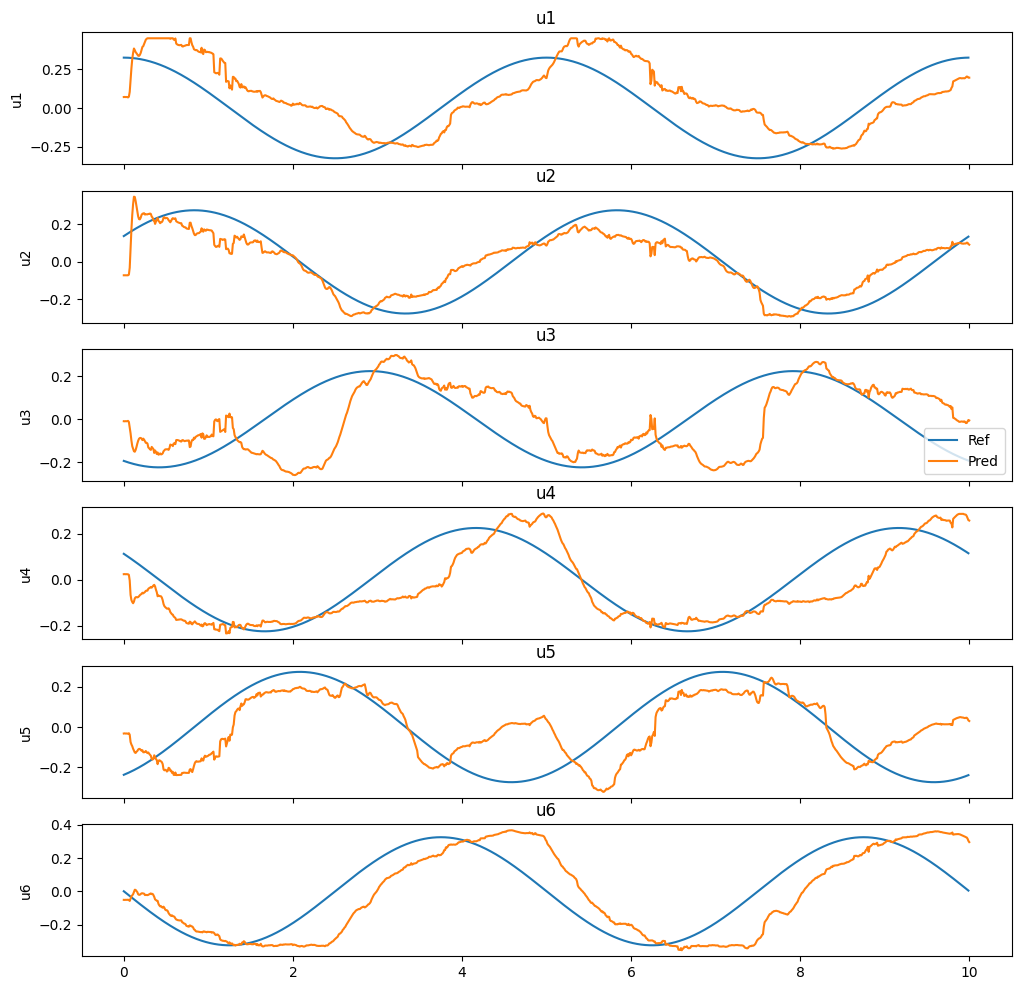

In [29]:
fig, axs = plt.subplots(6, 1, figsize=(12,12), sharex=True)
time = us_ref['ID']/100 # time in s
time_pred = us_pred['ID']/100

# Plot u1
axs[0].plot(time, us_ref['u1'], label='Ref')
axs[0].plot(time_pred, us_pred['u1'], label='Pred')
axs[0].set_title("u1")
axs[0].set_ylabel("u1")

# Plot u2
axs[1].plot(time, us_ref['u2'], label='Ref')
axs[1].plot(time_pred, us_pred['u2'], label='Pred')
axs[1].set_title("u2")
axs[1].set_ylabel("u2")

# Plot u3
axs[2].plot(time, us_ref['u3'], label='Ref')
axs[2].plot(time_pred, us_pred['u3'], label='Pred')
axs[2].set_title("u3")
axs[2].set_ylabel("u3")

# Plot u4
axs[3].plot(time, us_ref['u4'], label='Ref')
axs[3].plot(time_pred, us_pred['u4'], label='Pred')
axs[3].set_title("u4")
axs[3].set_ylabel("u4")

# Plot u5
axs[4].plot(time, us_ref['u5'], label='Ref')
axs[4].plot(time_pred, us_pred['u5'], label='Pred')
axs[4].set_title("u5")
axs[4].set_ylabel("u5")

# Plot u6
axs[5].plot(time, us_ref['u6'], label='Ref')
axs[5].plot(time_pred, us_pred['u6'], label='Pred')
axs[5].set_title("u6")
axs[5].set_ylabel("u6")



axs[2].legend(loc="lower right")